In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_loader, test_loader = mnist()

In [8]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=1.0)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [9]:
def train(epoch, models):
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in models.items()])
        print(line + losses)

In [10]:
def test(models, log=None):
    test_size = len(test_loader.dataset)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in test_loader:
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [11]:
models = {'softmax' : Net(), 'log_softmax' : Net(True)}
test_log = {k: [] for k in models}

epochs = 50
for epoch in range(1, epochs+1):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, test_log)

Train Epoch: 1 [0/60000 (0%)]	Losses softmax: 2.344637 log_softmax: 2.355945
Train Epoch: 1 [10000/60000 (17%)]	Losses softmax: 0.440703 log_softmax: 0.418357
Train Epoch: 1 [20000/60000 (33%)]	Losses softmax: 0.122335 log_softmax: 0.102184
Train Epoch: 1 [30000/60000 (50%)]	Losses softmax: 0.024474 log_softmax: 0.025550
Train Epoch: 1 [40000/60000 (67%)]	Losses softmax: 0.159236 log_softmax: 0.211564
Train Epoch: 1 [50000/60000 (83%)]	Losses softmax: 0.117807 log_softmax: 0.131648
Train Epoch: 1 [60000/60000 (100%)]	Losses softmax: 0.166018 log_softmax: 0.145383
Test set:
softmax: Loss: 0.1276	Accuracy: 9617.0/10000 (96%)
log_softmax: Loss: 0.1291	Accuracy: 9612.0/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Losses softmax: 0.072701 log_softmax: 0.096358
Train Epoch: 2 [10000/60000 (17%)]	Losses softmax: 0.097875 log_softmax: 0.069380
Train Epoch: 2 [20000/60000 (33%)]	Losses softmax: 0.121207 log_softmax: 0.119675
Train Epoch: 2 [30000/60000 (50%)]	Losses softmax: 0.212411 log_softmax:

Train Epoch: 13 [10000/60000 (17%)]	Losses softmax: 0.002329 log_softmax: 0.001423
Train Epoch: 13 [20000/60000 (33%)]	Losses softmax: 0.005348 log_softmax: 0.002815
Train Epoch: 13 [30000/60000 (50%)]	Losses softmax: 0.001109 log_softmax: 0.002853
Train Epoch: 13 [40000/60000 (67%)]	Losses softmax: 0.001730 log_softmax: 0.001074
Train Epoch: 13 [50000/60000 (83%)]	Losses softmax: 0.002601 log_softmax: 0.001600
Train Epoch: 13 [60000/60000 (100%)]	Losses softmax: 0.001695 log_softmax: 0.002085
Test set:
softmax: Loss: 0.0633	Accuracy: 9818.0/10000 (98%)
log_softmax: Loss: 0.0645	Accuracy: 9819.0/10000 (98%)

Train Epoch: 14 [0/60000 (0%)]	Losses softmax: 0.000600 log_softmax: 0.000830
Train Epoch: 14 [10000/60000 (17%)]	Losses softmax: 0.001057 log_softmax: 0.001591
Train Epoch: 14 [20000/60000 (33%)]	Losses softmax: 0.001059 log_softmax: 0.000637
Train Epoch: 14 [30000/60000 (50%)]	Losses softmax: 0.006575 log_softmax: 0.004676
Train Epoch: 14 [40000/60000 (67%)]	Losses softmax: 0.003

Train Epoch: 25 [10000/60000 (17%)]	Losses softmax: 0.000931 log_softmax: 0.000644
Train Epoch: 25 [20000/60000 (33%)]	Losses softmax: 0.001709 log_softmax: 0.001924
Train Epoch: 25 [30000/60000 (50%)]	Losses softmax: 0.001502 log_softmax: 0.001282
Train Epoch: 25 [40000/60000 (67%)]	Losses softmax: 0.001062 log_softmax: 0.000970
Train Epoch: 25 [50000/60000 (83%)]	Losses softmax: 0.000943 log_softmax: 0.001083
Train Epoch: 25 [60000/60000 (100%)]	Losses softmax: 0.001852 log_softmax: 0.002705
Test set:
softmax: Loss: 0.0677	Accuracy: 9819.0/10000 (98%)
log_softmax: Loss: 0.0676	Accuracy: 9820.0/10000 (98%)

Train Epoch: 26 [0/60000 (0%)]	Losses softmax: 0.000790 log_softmax: 0.001153
Train Epoch: 26 [10000/60000 (17%)]	Losses softmax: 0.000697 log_softmax: 0.000809
Train Epoch: 26 [20000/60000 (33%)]	Losses softmax: 0.000269 log_softmax: 0.000320
Train Epoch: 26 [30000/60000 (50%)]	Losses softmax: 0.001449 log_softmax: 0.000977
Train Epoch: 26 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 37 [10000/60000 (17%)]	Losses softmax: 0.000634 log_softmax: 0.000606
Train Epoch: 37 [20000/60000 (33%)]	Losses softmax: 0.000645 log_softmax: 0.000850
Train Epoch: 37 [30000/60000 (50%)]	Losses softmax: 0.001067 log_softmax: 0.000967
Train Epoch: 37 [40000/60000 (67%)]	Losses softmax: 0.000513 log_softmax: 0.000780
Train Epoch: 37 [50000/60000 (83%)]	Losses softmax: 0.000167 log_softmax: 0.000133
Train Epoch: 37 [60000/60000 (100%)]	Losses softmax: 0.000380 log_softmax: 0.000498
Test set:
softmax: Loss: 0.0700	Accuracy: 9821.0/10000 (98%)
log_softmax: Loss: 0.0694	Accuracy: 9819.0/10000 (98%)

Train Epoch: 38 [0/60000 (0%)]	Losses softmax: 0.000193 log_softmax: 0.000204
Train Epoch: 38 [10000/60000 (17%)]	Losses softmax: 0.001128 log_softmax: 0.000884
Train Epoch: 38 [20000/60000 (33%)]	Losses softmax: 0.000842 log_softmax: 0.000754
Train Epoch: 38 [30000/60000 (50%)]	Losses softmax: 0.000762 log_softmax: 0.000691
Train Epoch: 38 [40000/60000 (67%)]	Losses softmax: 0.000

Train Epoch: 49 [10000/60000 (17%)]	Losses softmax: 0.000366 log_softmax: 0.000458
Train Epoch: 49 [20000/60000 (33%)]	Losses softmax: 0.000348 log_softmax: 0.000344
Train Epoch: 49 [30000/60000 (50%)]	Losses softmax: 0.000076 log_softmax: 0.000124
Train Epoch: 49 [40000/60000 (67%)]	Losses softmax: 0.001007 log_softmax: 0.000584
Train Epoch: 49 [50000/60000 (83%)]	Losses softmax: 0.000190 log_softmax: 0.000361
Train Epoch: 49 [60000/60000 (100%)]	Losses softmax: 0.000295 log_softmax: 0.000259
Test set:
softmax: Loss: 0.0718	Accuracy: 9821.0/10000 (98%)
log_softmax: Loss: 0.0711	Accuracy: 9820.0/10000 (98%)

Train Epoch: 50 [0/60000 (0%)]	Losses softmax: 0.000771 log_softmax: 0.000654
Train Epoch: 50 [10000/60000 (17%)]	Losses softmax: 0.000278 log_softmax: 0.000226
Train Epoch: 50 [20000/60000 (33%)]	Losses softmax: 0.000113 log_softmax: 0.000153
Train Epoch: 50 [30000/60000 (50%)]	Losses softmax: 0.000364 log_softmax: 0.000150
Train Epoch: 50 [40000/60000 (67%)]	Losses softmax: 0.000

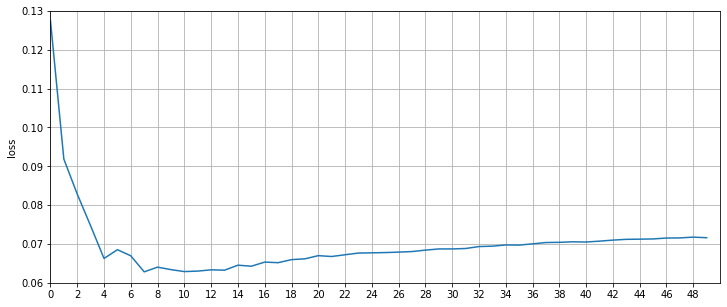

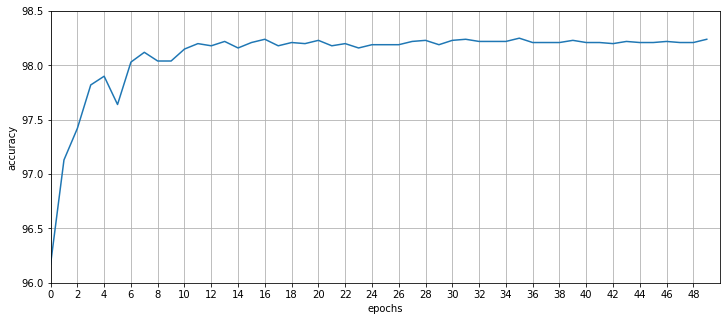

In [14]:
test_loss_softmax = [i[0] for i in test_log['softmax']]
test_acc_softmax = [i[1] for i in test_log['softmax']]
test_loss_log_softmax = [i[0] for i in test_log['log_softmax']]
test_acc_log_softmax = [i[1] for i in test_log['log_softmax']]

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_loss_softmax)
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((0.06, 0.13))
plt.ylabel('loss')
plt.grid()

plt.figure(figsize=(12, 5))
plt.plot(range(0, epochs), test_acc_softmax)
plt.xlabel('epochs')
plt.xticks(range(0, epochs, 2))
plt.xlim((0, 50))
plt.ylim((96, 98.5))
plt.ylabel('accuracy')
plt.grid()

In [15]:
test_loss_softmax[49]

0.07160903164073824